In [1]:
pip install emukit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emukit: filename=emukit-0.4.10-py3-none-any.whl size=257071 sha256=84f35ba9e83fd9ed50d0a9fd2a1c9bb4297675adccc4ccf982a156891ba4f109
  Stored in directory: /root/.cache/pip/wheels/30/d1/af/64ddede19b5eb77bd70362edebf9d393bf77dc34d354c11292
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102564 sha256=339f596adaf388a9

In [2]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

In [3]:
pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssDNS.csv') 
#RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/LinewssRANS.csv') 
DNS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/lineexploitDNSzero.csv') 
RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/lineexploitRANSzero.csv') 
# 
# RANS_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/WSSLowcostRANS_zero.csv') 




Mounted at /content/drive


In [5]:
# Generate sample data

x_train_l =  np.array([[70,100],[70,80],[70,50],[70,30],[70,0],[60,100],[60,80],[60,50],[60,30],[60,0],[50,100],[50,80],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,30],[40,0]])
x_train_h = np.array([[70,100],[70,0],[60,80],[50,50],[40,100],[40,0]])

DNS_full=DNS_data.dropna(axis=1)
DNS_full=DNS_full.values
DNS=DNS_full[:,[0,2,3,7,8,10]]
DNS=DNS[50:100,:]

DNS_test=DNS_full[:,[1,4,5,6,9]]
DNS_test=DNS_test[50:100,:]

RANS=RANS_data.dropna(axis=1)
RANS_full=RANS.values

RANS_test=RANS_full[:,[0,1,3,4,5,6,7,10,12,13,14,15,16,17,19]]
RANS=RANS_full[50:100,:]
RANS_test=RANS_test[50:100,:]
#D_70_100=np.array(DNS_data['70_100'])
#D_70_100=D_70_100.reshape(-1,1)
#np.stack(())
#print(column_values.shape)

DNS_full=np.transpose(DNS_full)
y_train_h=np.transpose(DNS)
y_train_l=np.transpose(RANS)


print(np.shape(y_train_h))
print(np.shape(y_train_l))

(6, 50)
(20, 50)


In [6]:
# x_train_l=np.c_[ x_train_l, np.zeros(len(x_train_l)) ]   
# x_train_h=np.c_[ x_train_h, np.ones(len(x_train_h)) ]   
# X_train=np.append(x_train_l,x_train_h,axis=0)
# 
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

# Y_train=np.append(y_train_h,y_train_l,axis=0)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])
print(X_train.shape)
print(Y_train.shape)

print(X_train)

(26, 3)
(26, 50)
[[ 70. 100.   0.]
 [ 70.  80.   0.]
 [ 70.  50.   0.]
 [ 70.  30.   0.]
 [ 70.   0.   0.]
 [ 60. 100.   0.]
 [ 60.  80.   0.]
 [ 60.  50.   0.]
 [ 60.  30.   0.]
 [ 60.   0.   0.]
 [ 50. 100.   0.]
 [ 50.  80.   0.]
 [ 50.  50.   0.]
 [ 50.  30.   0.]
 [ 50.   0.   0.]
 [ 40. 100.   0.]
 [ 40.  80.   0.]
 [ 40.  50.   0.]
 [ 40.  30.   0.]
 [ 40.   0.   0.]
 [ 70. 100.   1.]
 [ 70.   0.   1.]
 [ 60.  80.   1.]
 [ 50.  50.   1.]
 [ 40. 100.   1.]
 [ 40.   0.   1.]]


In [164]:
## Create standard GP model using only high-fidelity data
x_train_DNS=x_train_h
y_train_DNS=y_train_h
kernelDNS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,5.0],variance=0.0001, ARD=True)
kernelDNS.lengthscale.constrain_bounded(0,10000)
kernelDNS.variance.constrain_bounded(0,10)
high_gp_model = GPy.models.GPRegression(x_train_DNS, y_train_DNS, kernelDNS)
high_gp_model.Gaussian_noise.unfix()

## Fit the GP model

high_gp_model.optimize_restarts(100)


Optimization restart 1/100, f = -545.2872441339463
Optimization restart 2/100, f = -811.5877608816162
Optimization restart 3/100, f = -827.6628136602851
Optimization restart 4/100, f = -827.6628136603236
Optimization restart 5/100, f = -592.6329684314286


 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 6/100, f = -827.6628136565862
Optimization restart 7/100, f = -545.2915269234193
Optimization restart 8/100, f = -607.70549972574
Optimization restart 9/100, f = -811.5877548623465
Optimization restart 10/100, f = -827.6628136603202
Optimization restart 11/100, f = -827.6628136555477
Optimization restart 12/100, f = -545.2871449973776
Optimization restart 13/100, f = -599.8521232186231
Optimization restart 14/100, f = -827.6628136602569
Optimization restart 15/100, f = -811.588063483862
Optimization restart 16/100, f = -827.6628128207208
Optimization restart 17/100, f = -599.0401266392212
Optimization restart 18/100, f = -401.88590726723714
Optimization restart 19/100, f = -827.6628136602267
Optimization restart 20/100, f = -811.5882532379317
Optimization restart 21/100, f = -827.6628136600938
Optimization restart 22/100, f = -545.2918005898241
Optimization restart 23/100, f = -590.5924054971746
Optimization restart 24/100, f = -827.6628136601353
Optimization resta

In [172]:
print(high_gp_model.ExpQuad.lengthscale[0])
print(high_gp_model.ExpQuad.lengthscale[1])
print(high_gp_model.ExpQuad.variance)
print(high_gp_model.gradient)
# Get the gradients of optimization
gradients_dns = high_gp_model.gradient

# Get the names of the model's parameters
parameter_dns = high_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_dns)):
    print(f"Parameter: {parameter_dns[i]} - Gradient: {gradients_dns[i]}")


37.37772039595029
1242.8444970292262
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      0.00890546  |   0.0,10.0    |        
[ 7.27600629e-04 -5.51508198e-07  1.19777043e-09 -1.05095124e-01]
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: 0.0007276006292499751
Parameter: ExpQuad.lengthscale - Gradient: -5.515081978973576e-07
Parameter: Gaussian_noise.variance - Gradient: 1.1977704296328577e-09


In [41]:
## Create standard GP model using only low-fidelity data

x_train_RANS= np.array([[70,100],[70,80],[70,30],[70,0],[60,100],[60,80],[60,50],[50,100],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,0]])

y_train_RANS=np.transpose(RANS_test)
print(y_train_RANS.shape)

(15, 50)


In [287]:
kernelRANS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.05, ARD=True)
kernelRANS.lengthscale.constrain_bounded(0,1000)
kernelRANS.variance.constrain_bounded(0,10)
low_gp_model = GPy.models.GPRegression(x_train_RANS, y_train_RANS, kernelRANS)
low_gp_model.Gaussian_noise.unfix()

## Fit the GP model

low_gp_model.optimize_restarts(500)

Optimization restart 1/500, f = -1626.2069310898855
Optimization restart 2/500, f = -1767.234131499058
Optimization restart 3/500, f = -1767.2341310843683
Optimization restart 4/500, f = -1759.429556110628
Optimization restart 5/500, f = -1767.2341315026652
Optimization restart 6/500, f = -1759.4270495631226
Optimization restart 7/500, f = -1767.2341315270492
Optimization restart 8/500, f = -1759.4237063749372
Optimization restart 9/500, f = -1767.2341315267813
Optimization restart 10/500, f = -1767.2341315270496
Optimization restart 11/500, f = -1767.2341315267854
Optimization restart 12/500, f = -1759.4225231260452
Optimization restart 13/500, f = -1767.234131527031
Optimization restart 14/500, f = -1759.421105475052
Optimization restart 15/500, f = -1767.2341315264187
Optimization restart 16/500, f = -1759.4211655957365
Optimization restart 17/500, f = -1759.4211099515805
Optimization restart 18/500, f = -1767.2341315270378
Optimization restart 19/500, f = -1767.2341313571694
Optimi

In [289]:
print(low_gp_model.ExpQuad.lengthscale[0])
print(low_gp_model.ExpQuad.lengthscale[1])
print(low_gp_model.ExpQuad.variance)

# Get the gradients of optimization
gradients_rans = low_gp_model.gradient

# Get the names of the model's parameters
parameter_rans = low_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_rans)):
    print(f"Parameter: {parameter_rans[i]} - Gradient: {gradients_rans[i]}")


39.704264831187615
402.4383966513285
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      0.00335516  |   0.0,10.0    |        
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: 3.146148127231655e-05
Parameter: ExpQuad.lengthscale - Gradient: 8.82153373991347e-08
Parameter: Gaussian_noise.variance - Gradient: 8.903672209641858e-10


In [296]:
kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True),GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True)]
# for kernel in kernels:
#     kernel.lengthscale.constrain_bounded(0, 50)
#     kernel.variance.constrain_bounded(0, 10)
for i, kernel in enumerate(kernels):
    if i == 0:  # First fidelity
        kernel.lengthscale.constrain_bounded(0, 25)
        kernel.variance.constrain_bounded(0, 5)
    elif i == 1:  # Second fidelity
        kernel.lengthscale.constrain_bounded(0, 25)
        kernel.variance.constrain_bounded(0, 10)   
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.unfix()
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.unfix()

lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)

## Fit the model
  
lin_mf_model.optimize()

Optimization restart 1/5, f = -3203.9639933636618
Optimization restart 2/5, f = -3211.0434274988875
Optimization restart 3/5, f = -3211.049324788677
Optimization restart 4/5, f = -3134.898409200673
Optimization restart 5/5, f = -3123.276592064351


In [297]:
 print(gpy_lin_mf_model)


Name : gp
Objective : -3211.049324788677
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  gp.                                    |                   value  |  constraints  |  priors
  multifidelity.ExpQuad.variance         |   0.0018218251972006768  |    0.0,5.0    |        
  multifidelity.ExpQuad.lengthscale      |                    (2,)  |   0.0,25.0    |        
  multifidelity.ExpQuad_1.variance       |   3.108299368695635e-12  |   0.0,10.0    |        
  multifidelity.ExpQuad_1.lengthscale    |                    (2,)  |   0.0,25.0    |        
  multifidelity.scale                    |      1.1363337219653786  |               |        
  mixed_noise.Gaussian_noise.variance    |  5.9746289115108116e-05  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  2.1714122095653234e-09  |      +ve      |        


In [298]:
  print(gpy_lin_mf_model.multifidelity.ExpQuad.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad.lengthscale)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.lengthscale)

  index  |  gp.multifidelity.ExpQuad.variance  |  constraints  |  priors
  [0]    |                         0.00182183  |    0.0,5.0    |        
  index  |  gp.multifidelity.ExpQuad_1.variance  |  constraints  |  priors
  [0]    |                           0.00000000  |   0.0,10.0    |        
  index  |  gp.multifidelity.ExpQuad.lengthscale  |  constraints  |  priors
  [0]    |                           11.85258039  |   0.0,25.0    |        
  [1]    |                           24.99999905  |   0.0,25.0    |        
  index  |  gp.multifidelity.ExpQuad_1.lengthscale  |  constraints  |  priors
  [0]    |                             22.85142895  |   0.0,25.0    |        
  [1]    |                             23.40815450  |   0.0,25.0    |        


In [299]:
# Get the gradients of optimization
gradients_mf = gpy_lin_mf_model.multifidelity.gradient

# Get the names of the model's parameters
parameter_mf = gpy_lin_mf_model.multifidelity.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_mf)):
    print(f"Parameter: {parameter_mf[i]} - Gradient: {gradients_mf[i]}")

Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: 2.690117785429024
Parameter: ExpQuad.lengthscale - Gradient: -0.0016446515079089942
Parameter: ExpQuad_1.variance - Gradient: 3.37977885061361
Parameter: ExpQuad_1.lengthscale - Gradient: 1376006.7608020573
Parameter: scale - Gradient: 1.0688706903694759e-07


In [291]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[70,50],[60,30],[60,0],[50,80],[40,30]])
X_plot_l=np.c_[ x_plot, np.zeros(len(x_plot)) ]   
X_plot_h=np.c_[ x_plot, np.ones(len(x_plot)) ]  

In [292]:
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)

hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(X_plot_h)
lf_mean_low_gp_model, lf_var_low_gp_model  = low_gp_model.predict(X_plot_h)

In [293]:
# print(np.amax(hf_mean_lin_mf_model))
print(np.sqrt(hf_var_lin_mf_model)*1.96)
print(np.sqrt(hf_var_high_gp_model)*1.96)
print(np.sqrt(lf_var_low_gp_model)*1.96)
# c=(hf_mean_lin_mf_model.shape)
# print(c)



[[0.01232299]
 [0.01442825]
 [0.01168421]
 [0.01332002]
 [0.01307229]]
[[0.00584195]
 [0.00632142]
 [0.0069358 ]
 [0.0061195 ]
 [0.00594191]]
[[0.03642434]
 [0.03548131]
 [0.03669926]
 [0.03528839]
 [0.03658075]]


In [222]:
print(hf_mean_lin_mf_model)
print(hf_mean_high_gp_model)
print(lf_mean_low_gp_model)

[[ 0.00651825  0.00722494  0.00753264  0.00848637  0.00971338  0.01148411
   0.01390818  0.0169142   0.02057294  0.02504983  0.0306757   0.03729348
   0.04491359  0.05363164  0.06397323  0.07542285  0.08773429  0.09557401
   0.10401001  0.11251383  0.12084316  0.12901038  0.13626098  0.14170854
   0.14168392  0.13524081  0.12780013  0.11978734  0.11097523  0.10076913
   0.08861964  0.07669416  0.06530753  0.05396975  0.04208828  0.02991856
   0.02114404  0.01495144  0.01112908  0.00880044  0.00652546  0.00462273
   0.00343533  0.00323368  0.00337467  0.00363176  0.00376148  0.00356675
   0.0032113   0.0029388 ]
 [ 0.00459235  0.0051139   0.00525447  0.00599136  0.00693817  0.00828235
   0.01016806  0.01253775  0.01544177  0.01901708  0.02352281  0.02883235
   0.03492428  0.04186143  0.05000699  0.05893796  0.06856186  0.07725269
   0.08641502  0.09556093  0.10433041  0.11215703  0.11870063  0.12319029
   0.12507601  0.12416376  0.11967181  0.11692306  0.11034112  0.09551722
   0.064285

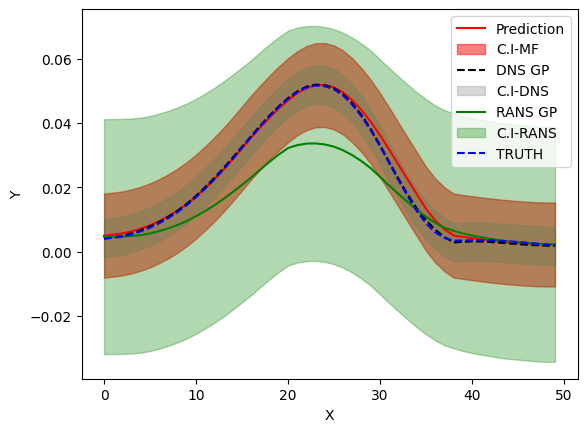

In [290]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
fig,ax=plt.subplots()
#DNS_test.shape[0]
i=4
x_pred = np.linspace(0,49,50).reshape(-1, 1)
# Calculate upper and lower confidence bounds
confidence = 1.96 # 95% confidence interval (approximate)
lower_bound = hf_mean_lin_mf_model[i]- confidence * np.sqrt(hf_var_lin_mf_model[i])
upper_bound = hf_mean_lin_mf_model[i]+ confidence * np.sqrt(hf_var_lin_mf_model[i])
ax.plot(hf_mean_lin_mf_model[i],color='r',label='Prediction')
ax.fill_between(x_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='red', alpha=0.5, label='C.I-MF')



#for i in range(1):
#ax.fill_between((hf_mean_lin_mf_model[0] - 1.96*hf_std_lin_mf_model[0]).flatten(), 
#(hf_mean_lin_mf_model[0] + 1.96*hf_std_lin_mf_model[0]).flatten(), color='r', alpha=0.3)
# ax.plot(RANS_test[:,i],color='k',linestyle='dotted',label='RANS')
ax.plot(hf_mean_high_gp_model[i],color='black',linestyle='--',label='DNS GP')
lower_bound_dns = hf_mean_high_gp_model[i]- confidence * np.sqrt(hf_var_high_gp_model[i])
upper_bound_dns = hf_mean_high_gp_model[i]+ confidence * np.sqrt(hf_var_high_gp_model[i])
ax.fill_between(x_pred.flatten(), lower_bound_dns.flatten(), upper_bound_dns.flatten(), color='gray', alpha=0.3, label='C.I-DNS')
ax.plot(lf_mean_low_gp_model[i],color='green',label='RANS GP')
lower_bound_rans = lf_mean_low_gp_model[i]- confidence * np.sqrt(lf_var_low_gp_model[i])
upper_bound_rans = lf_mean_low_gp_model[i]+ confidence * np.sqrt(lf_var_low_gp_model[i])
ax.fill_between(x_pred.flatten(), lower_bound_rans.flatten(), upper_bound_rans.flatten(), color='green', alpha=0.3, label='C.I-RANS')
ax.plot(DNS_test[:,i],color='b',linestyle='--',label='TRUTH')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()


# np.savetxt('MF_70_e50_dns5_rans_8.dat', zip(write_mf), fmt=['%.3f','%.3f'])
# np.savetxt('LF_70_e50_dns5_rans_8.dat', zip(x_data,y_lf), fmt=['%.3f','%.3f'])
# np.savetxt('HF_70_e50_dns5_rans_8.dat', zip(x_data,y_hf), fmt=['%.3f','%.3f'])

In [155]:
print(np.sqrt(hf_var_high_gp_model[i]))
# print(x_pred)
print(lf_var_low_gp_model)
print(hf_var_high_gp_model)
print(hf_var_lin_mf_model)

[0.00353867]
[[0.00034536]
 [0.00032771]
 [0.00035059]
 [0.00032415]
 [0.00034833]]
[[8.88391138e-06]
 [1.04020161e-05]
 [1.25221955e-05]
 [9.74808998e-06]
 [9.19052114e-06]]
[[3.23993818e-05]
 [3.25089594e-05]
 [3.25093369e-05]
 [3.25088733e-05]
 [3.23994291e-05]]


In [137]:
# # CI = np.ones(c[1])*1.96*hf_std_lin_mf_model[i,:].reshape(-1,1)
# # CI=CI.T
# # print(CI.shape)
# x_data=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/xshort_points.csv') 
# y_data=hf_mean_lin_mf_model[i].reshape(-1,1)
# y_hf=hf_mean_high_gp_model[i].reshape(-1,1)
# y_lf=lf_mean_low_gp_model[i].reshape(-1,1)
# print(y_data.shape)
# print(x_data.shape)
# write_mf = np.stack((x_data,y_data), axis = 1).reshape(-1,2)
# write_lf = np.stack((x_data,y_lf), axis = 1).reshape(-1,2)
# write_hf = np.stack((x_data,y_hf), axis = 1).reshape(-1,2)
# print(write_hf.shape)

# e= "streamwise WSS"
# hdrtxt='# xpoints','#ypoints'
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/MF_60_e0_dns6_rans_20.dat', write_mf, delimiter='  ' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/LF_60_e0_dns6_rans_20.dat', write_lf, delimiter='   ' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/HF_60_e0_dns6_rans_20.dat', write_hf, delimiter='   ' )

In [295]:
# # Define the range of x values for prediction
# x_pred = np.linspace(0,50, 50).reshape(-1, 1)

# # Predict mean and variance at the given x values
# mean, var = model.predict(x_pred)

# # Calculate upper and lower confidence bounds
# confidence = 1.96  # 95% confidence interval (approximate)
# lower_bound = mean - confidence * np.sqrt(var)
# upper_bound = mean + confidence * np.sqrt(var)

# # Plot the data points, mean, and confidence interval
# plt.scatter(X_train, Y_train, color='red', label='Training data')
# plt.plot(x_pred, mean, color='blue', label='Mean')
# plt.fill_between(x_pred.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Confidence interval')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('GPy Model Predictions with Confidence Interval')
# plt.legend()
# plt.show()

IndexError: ignored

In [ ]:
fig,ax=plt.subplots()
for i in range(hf_mean_lin_mf_model.shape[0]):
   ax.plot(hf_mean_lin_mf_model[i])
ax.set_xlabel('X')
ax.set_ylabel('Y')


In [ ]:
# i=4
# y_true=DNS_test[:,i].reshape(-1,1)
# # y_rans=RANS_test[:,i].reshape(-1,1)


# write_truth = np.stack((x_data,y_true), axis = 1).reshape(-1,2)
# # write_rans = np.stack((x_data,y_rans), axis = 1).reshape(-1,2)


# np.savetxt('/content/drive/MyDrive/ColabNotebooks/Truth_40_e30.dat', write_truth, delimiter='  ' )
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/RANS_70_e50.dat', write_rans, delimiter='   ' )


In [ ]:
DNS_test=np.transpose(DNS_test)
fig,ax=plt.subplots()
for i in range(DNS_test.shape[1]):
   ax.plot(DNS_test[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.plot(hf_mean_lin_mf_model[2],color='r',linestyle='dotted',label='Prediction')


In [ ]:

fig,ax=plt.subplots()
for i in range(RANS_full.shape[1]):
   ax.plot(RANS_full[:,i])
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [ ]:
  print(DNS_test[0])


In [ ]:
plt.figure(figsize=(12,8))
plt.ylabel('HF(x)')
plt.xlabel('LF(x)')

plt.plot(y_train_l[[0,2,4,7,8,10],:], y_train_h, color='purple',marker='*',)
plt.title('Mapping from low fidelity to high fidelity')
plt.legend(['HF-LF Correlation'], loc='lower center');

In [ ]:
print(Y_train)

In [ ]:
print(Y_train.shape)

In [ ]:

kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001),GPy.kern.ExpQuad(input_dim=2,lengthscale=5.0,variance=0.0001)]

lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)

#gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=500)

## Fit the model
  
lin_mf_model.optimize()